In [31]:
import requests
import os
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [10]:
# tweaked from https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPModel.forward.returns

# below is standard CLIP usage to score text snippets against a photo

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [13]:
def images_to_embeddings(images):
    vinput = processor(images=images, return_tensors="pt")

    voutput = model.vision_model(
        **vinput
    )

    vembeds = voutput[1]

    vembeds = model.visual_projection(vembeds)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

# build amazon dataset

download dataset from https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson

In [250]:



class AmazonClothingDataset(Dataset):
    @staticmethod
    def download_records(download_dir):
        os.makedirs(download_dir, exist_ok=True)
        print(download_dir)
        
        _url = "https://query.data.world/s/pnnl7xgiifupk3sa6odnwr4m7fvmn4?dws=00000"
    
        records_path = wget.download(_url, out=download_dir)
        
        return records_path

    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records
    
    def _download(self, record):
        md = None
        try:
            image_url = record["medium"].split("|")[0]
            image_path = os.path.join(self.image_dir, record["uniq_id"] + ".jpg")

            if not os.path.exists(image_path):
                image = Image.open(requests.get(image_url, stream=True).raw)
                image.save(image_path)

                label = f"a catalog photo of {record['product_name']}"

                category = list(record["parent___child_category__all"].keys())[1]

                md = {
                    "product_id": record["uniq_id"],
                    "image_path": image_path,
                    "image_url": image_url,
                    "label": label,
                    "category": category,
                }
        except:
            md = None

        return md

    @staticmethod
    def _thread_run(f, my_iter):
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        return results


    def __init__(self, image_dir, records):

        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
        
        mds = self._thread_run(self._download, records)
        mds = [md for md in mds if md is not None]
    
        self.metadata = pd.DataFrame(mds)
        
    def __getitem__(self, idx):
        md = self.metadata.iloc[idx]
        
        try:
            image = Image.open(md.image_path)

        except:
            image = None

        return (image, md.label, md.category)
    
    def __len__(self,):
        return len(self.metadata)
    
    def subset_by_category(self, category):
        records = []
        for i, record in enumerate(self.records):
            rcategory = list(record["parent___child_category__all"].keys())[1]
            
            if rcategory == category:
                records.append(record)

        return AmazonClothingDataset(image_dir=self.image_dir, records=records)
    
    def get_category_indices(self, category):
        md = self.metadata[self.metadata.category == category]
        return md.index

In [ ]:
download_dir = '/Users/jsb/data/amazon_clothing_2020/test/'

if not os.path.exists(os.path.join(download_dir, "marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson")):
    fpath = AmazonClothingDataset.download_records(download_dir=download_dir)

records = AmazonClothingDataset.read_records(fpath)
amazon_dataset2 = AmazonClothingDataset(image_dir=download_dir, records=records)

 35%|█████████████████▍                                | 10479/30000 [03:03<04:49, 67.55it/s]

# pre-calculate embeddings for all dataset products

In [89]:
def collate_fn(batch):
    images, labels, categories = [], [], []
    for item in batch:
        image, label, category = item
        if image is not None:
            images.append(image)
            labels.append(label)
            categories.append(category)        
    return images, labels, categories


data_loader = DataLoader(
    dataset = amazon_dataset2,
    collate_fn = collate_fn,
    batch_size = 32,
    shuffle = False,
)

In [124]:
embeddings_path = os.path.join(download_dir, 'amazon_embeddings.npy')

if not os.path.exists(embeddings_path):
    candidate_vembeds = []

    count = 0
    for imgs, labs, cats in tqdm(data_loader):
        count += len(imgs)
        with torch.no_grad():
            candidate_vembeds.append(images_to_embeddings(imgs))

    candidate_vembeds = torch.concat(candidate_vembeds)
    candidate_vembeds = candidate_vembeds.detach().numpy()
    np.save("/Users/jsb/repos/moodboard/amazon_embeddings.npy", candidate_vembeds)

candidate_vembeds = np.load(embeddings_path)

# search over a category in the dataset

In [25]:
amazon_dataset2.metadata.category.unique()

array(['WomensKurtasKurtis', 'MensT_Shirts', 'MensTracksuits',
       'MensShorts', 'MensCasualShirts', 'GirlsDressesJumpsuits',
       'GirlsT_Shirts', 'MensUnderwearBriefs', 'WomensDresses',
       'WomensClothing', 'WomensT_Shirts', 'WomensSarees', 'MensPolos',
       'MaternityDresses', 'WomensTops', 'BoysPyjamaSets', 'BoysTies',
       'MensFormalShirts', 'WomensLehengaCholis', 'WomensSportsBras',
       'WomensChuridarSalwarBottoms', 'BoysT_Shirts',
       'WomensThermalBottoms', 'WomensEthnicGowns',
       'WomensNightiesNightdresses', 'WomensSportsShorts',
       'WomensTrousers', 'MensUnderwearVests', 'WomensBlousesShirts',
       'MensSuspenders', 'MensNeckties', 'WomensSalwarSuits',
       'WomensPulloverSweaters', 'WomensBikiniKnickers', 'MensJeans',
       'MensSportsT_ShirtsJerseys', 'BoysSweaters', 'BoysShirts',
       'WomensEthnicUnstitchedFabric', 'MensCapsHats',
       'WomensSweatshirtsHoodies', 'MensFormalTrousers', 'MensDhoties',
       'WomensLoungeShorts', 'Mens

In [ ]:
def search(image_url, category, k=10):
    image = Image.open(requests.get(image_url, stream=True).raw)
    with torch.no_grad():
        query_vembeds = images_to_embeddings([image])
    query_vembeds = query_vembeds.detach().numpy()

    category_idxs = amazon_dataset2.get_category_indices(category)

    category_vembeds = candidate_vembeds[category_idxs]

    dim = query_vembeds.shape[1]

    index = faiss.IndexFlatIP(dim)

    index.add(category_vembeds)

    dists, idxs = index.search(query_vembeds, k)

    # plot
    dataset_idxs = []
    for idx in idxs[0]:
        dataset_idxs.append(category_idxs[idx])
    return dataset_idxs

## example search

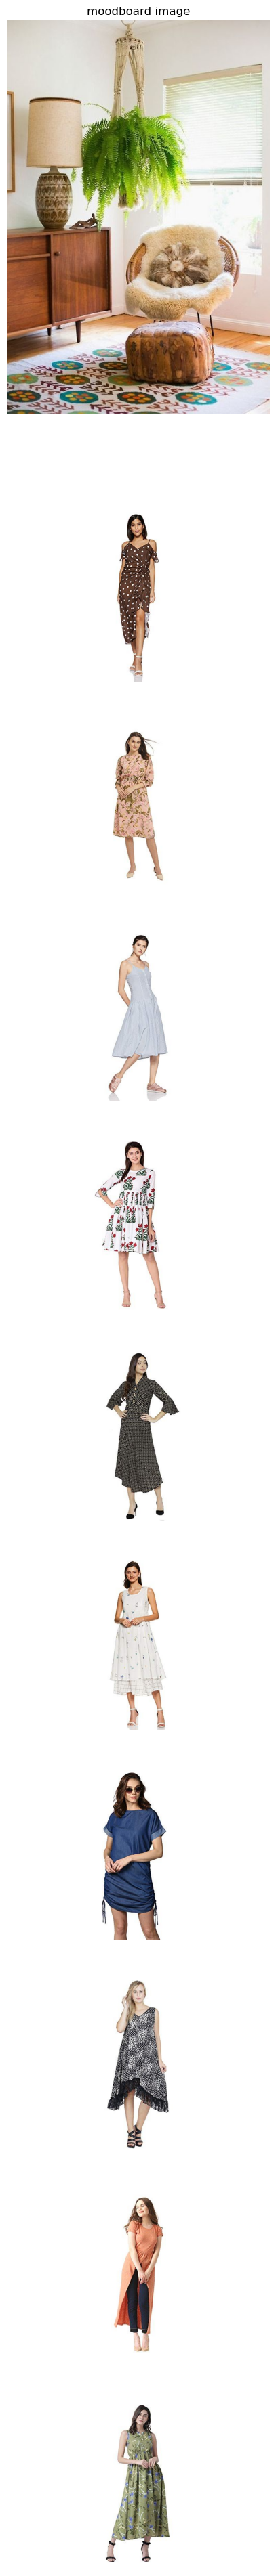

In [184]:
# get our query embeddings
image_url = "https://i.pinimg.com/564x/2a/da/f7/2adaf77f93508acd3e2d3448768be26b.jpg"
category = "WomensDresses"
k = 10

dataset_idxs = search(image_url, category, k=k)

# plot
image = Image.open(requests.get(image_url, stream=True).raw)

fig, axes = plt.subplots(1 + k, 1, 
                         figsize = (5, 50), 
                         gridspec_kw={'height_ratios': [3] + [1] * k,})

for ax in axes.ravel():
    ax.axis("off")
    
axes[0].imshow(image)
axes[0].set_title("moodboard image")

for iax in range(k):
    ax = axes[iax + 1]
    idx = dataset_idxs[iax]
    ax.imshow(amazon_dataset2[idx][0])
    ax.set_aspect("equal")

plt.subplots_adjust(hspace=0.2, wspace = 0.0)
plt.show()

In [180]:
idx

10605